In [1]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns                                   # For pretty plot
from datetime import datetime, timedelta

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict


%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 50     

In [2]:
power = pd.read_csv('ELL data/power.csv',sep=';')
irrad = pd.read_csv('ELL data/irradiance.csv',sep=';')

In [3]:
power.replace(to_replace='null', value=0, inplace=True)
irrad.replace(to_replace='null', value=0, inplace=True)

In [4]:
power['power'] = power['power'].astype(float)
irrad['irradiance'] = irrad['irradiance'].astype(float)

In [5]:
power.head()

,time,power
0,2016-01-01T01:00:00.000Z,0.0
1,2016-01-01T01:01:00.000Z,0.0
2,2016-01-01T01:02:00.000Z,0.0
3,2016-01-01T01:03:00.000Z,0.0
4,2016-01-01T01:04:00.000Z,0.0


In [6]:
def get_timestamp_from_time(y,mons,d,h,mins,s):
    return (datetime(y,mons,d,h,mins,s) - datetime(2016, 1, 1, 1, 0, 0))  //timedelta(seconds=1)

In [7]:
seconds = power['time'].apply(lambda x: (datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ")  - datetime(2016, 1, 1, 1, 0, 0))  //timedelta(seconds=1))

In [8]:
power['timestamp'] = seconds
irrad['timestamp'] = seconds

In [9]:
ts_double = get_timestamp_from_time(2016,5,24,7,31,0)

In [10]:
indx = power[power.timestamp >= ts_double].index

In [11]:
x = power.loc[power.timestamp >= ts_double]['power']
x.head()

207751    0.0
207752    0.0
207753    0.0
207754    0.0
207755    0.0
Name: power, dtype: float64

In [12]:
y = power.loc[power.timestamp >= ts_double]['power'] /2
y.head()

207751    0.0
207752    0.0
207753    0.0
207754    0.0
207755    0.0
Name: power, dtype: float64

In [13]:
power.ix[power.timestamp >= ts_double, 'power'] = y

In [14]:
power.loc[indx].head()

,time,power,timestamp
207751,2016-05-24T07:31:00.000Z,0.0,12465060
207752,2016-05-24T07:32:00.000Z,0.0,12465120
207753,2016-05-24T07:33:00.000Z,0.0,12465180
207754,2016-05-24T07:34:00.000Z,0.0,12465240
207755,2016-05-24T07:35:00.000Z,0.0,12465300


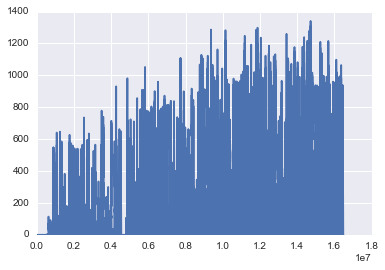

In [15]:
plt.plot(power['timestamp'], irrad['irradiance'])

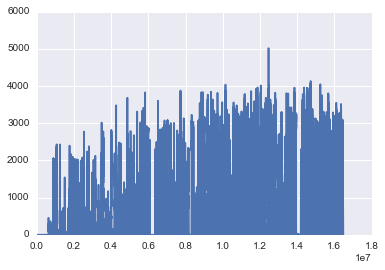

In [16]:
plt.plot(power['timestamp'], power['power'])

In [17]:
Pdc = power['power']
Gmi = irrad['irradiance']

In [18]:
regr = linear_model.LinearRegression()

In [19]:
#predicted = regr.fit(Gmi.reshape(-1,1), Pdc)
predicted = cross_val_predict(regr,Gmi.reshape(-1,1), Pdc, cv=10)

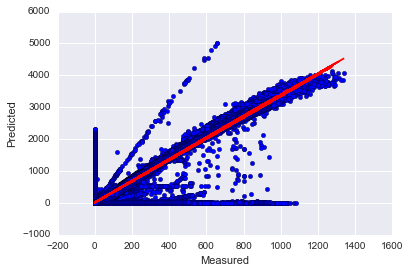

In [20]:
fig, ax = plt.subplots()
ax.scatter(Gmi, Pdc)
ax.plot(Gmi, predicted,'r--')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [21]:
regr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
pred = regr.fit(Gmi.reshape(-1,1), Pdc)

In [23]:
pred.predict(0)

array([ 9.76746751])

In [24]:
pred.predict(1)

array([ 13.12858174])

In [26]:
pred.predict(1000)

array([ 3370.88170062])